# FRA 503: Deep Reinforcement Learning
# Homework 1

## Part 1: Setting up Multi-armed Bandit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Bandit Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - hidden reward distributions สำหรับแต่ละ bandit (0-1 แทนโอกาสได้รางวัล 0-100%) 
2.  ฟังชั่น get_reward 
    - รับ bandit_index เพื่อระบุ Bandit ที่ถูกเลือก
    - สุ่มค่าโดยอิงตาม rate ที่กำหนดใน hidden reward distributions ถ้าถูกรางวัลจะ return 1 ไม่ถูกจะ return 0

In [2]:
class Bandit:
    def __init__(self, n_bandits, custom_rewards=None):
        # จำนวน Bandits
        self.n_bandits = n_bandits

        if custom_rewards is None:
            # สร้าง hidden reward distributions สำหรับแต่ละ bandit (สุ่มค่าความน่าจะเป็นระหว่าง 0 ถึง 1)
            self.reward_distributions = np.random.uniform(0, 1, self.n_bandits)
        else:
            # print(len(custom_rewards),n_bandits)
            if len(custom_rewards) == n_bandits:
                # ใช้ custom rewards ที่ผู้ใช้ให้มา
                self.reward_distributions = np.array(custom_rewards)
            else:
                raise ValueError("Custom rewards must be an array of length equal to n_bandits.")

    def get_reward(self, bandit_index):
        if 0 <= bandit_index < self.n_bandits:
            # สุ่มรางวัล: 1 (ถูกรางวัล) หรือ 0 (ไม่ถูกรางวัล) ตามความน่าจะเป็น
            return 1 if np.random.rand() < self.reward_distributions[bandit_index] else 0
            
            
        else:
            raise ValueError("Bandit index out of range!")



#### Agent Class 
1. ฟังชั่นตั้งต้นจะกำหนด
    - จำนวน Bandits
    - Learning Rate
    - Q-value
    - ค่าคงที่สำหรับ UCB
    - จำนวน timestep ทั้งหมด
    - action_probs ความน่าจะเป็นในการเลือกครั้งแรกจะเท่ากันทุก  bandit


2. ฟังชั่น select_action ใช้ในการเลือก bandits โดยตั้งต้นจะให้ใช้ UCB 
    - Epsilon-Greedy 
        
        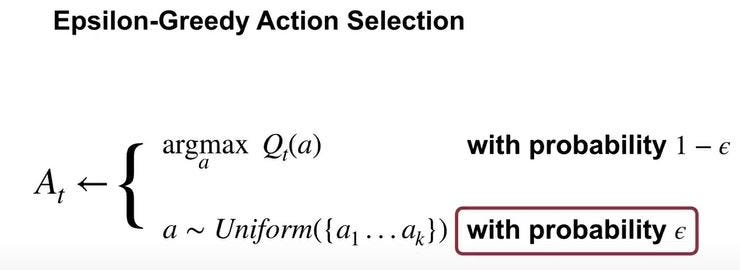

        
    - Upper Confidence Bound (UCB)
        
        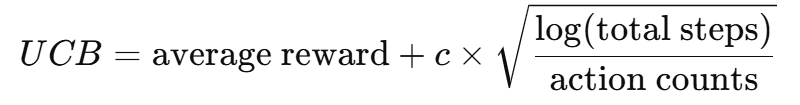



3. ฟังชั่น update




In [3]:
class Agent:
    def __init__(self, n_bandits ,c =2 , epsilon = 0.5):
        #จำนวน bandits
        self.n_bandits = n_bandits 
        # เริ่มต้นค่าประมาณการรางวัล (Q-value) และ policy (action distribution)
        self.q_values = np.zeros(n_bandits) 
        
        #Upper Confidence Bound (UCB)
        self.c = c  # ค่าคงที่สำหรับ UCB  
        self.total_steps = 0  # จำนวน timestep ทั้งหมด
        self.action_counts = np.zeros(n_bandits)  # จำนวนครั้งที่เลือกแต่ละ Bandit
        
        #Epsilon-Greedy
        self.epsilon = epsilon  # ค่า Epsilon สำหรับ Epsilon-Greedy
    
    def select_action_UCB(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Upper Confidence Bound (UCB)
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1
        ucb_values = np.zeros(self.n_bandits)
        
        for i in range(self.n_bandits):
            if self.action_counts[i] > 0:
                # ปรับสูตรความมั่นใจ (เพิ่ม +1 ในตัวหารเพื่อป้องกันหารด้วย 0)
                confidence = self.c * np.sqrt(np.log(self.total_steps) / (self.action_counts[i]))
                ucb_values[i] = self.q_values[i] + confidence
            else:
                # เลือก Bandit ที่ยังไม่เคยถูกเลือก
                return i
        
        # เลือก Bandit ที่มีค่า UCB สูงสุด
        return np.argmax(ucb_values)
    
    def select_action_epsilon_greedy(self):
        """
        เลือก Bandit โดยใช้อัลกอริทึม Epsilon-Greedy
        :return: ดัชนีของ Bandit ที่เลือก
        """
        self.total_steps += 1

        if np.random.rand() < self.epsilon:
            # Exploration: เลือก Bandit แบบสุ่ม
            return np.random.randint(0, self.n_bandits)
        else:
            # Exploitation: เลือก Bandit ที่มีค่า Q-value สูงสุด
            return np.argmax(self.q_values)
        
    
    def update(self, action, reward):
        """
        อัปเดต Q-value และจำนวนครั้งที่เลือก Bandit
        :param action: ดัชนีของ Bandit ที่เลือก
        :param reward: รางวัลที่ได้รับจาก Bandit นั้น
        """
        self.action_counts[action] += 1
        # อัปเดต Q-value แบบ incremental
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]

In [4]:
def run_experiment(n_bandits, n_steps, c=2, epsilon=0.5, method="UCB",custom_rewards=None):
    # print(f"custom_rewards at start: {custom_rewards}")  # Debug print
    bandit = Bandit(n_bandits,custom_rewards)
    agent = Agent(n_bandits, c, epsilon)

    rewards = []
    cumulative_rewards = []
    actions_selected = []

    for step in range(n_steps):
        # เลือกฟังก์ชันการเลือก Bandit ตาม method ที่กำหนด
        if method == "UCB":
            action = agent.select_action_UCB()
        elif method == "Epsilon-Greedy":
            action = agent.select_action_epsilon_greedy()
        else:
            raise ValueError("Invalid method. Choose 'UCB' or 'Epsilon-Greedy'.")

        # รับรางวัลจาก Bandit
        reward = bandit.get_reward(action)

        # อัปเดต Q-value และจำนวนครั้งที่เลือก
        agent.update(action, reward)

        # เก็บรางวัลและคำนวณรางวัลสะสมเฉลี่ย
        rewards.append(reward)
        cumulative_rewards.append(np.mean(rewards))
        actions_selected.append(action)
        # print(action)

    return rewards, cumulative_rewards, bandit.reward_distributions, actions_selected


## Part 2: Implementing epsilon-greedy algorithm.

## Experimental

**hypothesize**
1. If epsilon approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
2. If epsilon approaches to 1, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.

**Observation** : We analyzed the average reward for each epsilon value 3 times by change the most high reward around bandits and also oserve a graph's trend.

We conducted an experiment by running an epsilon-greedy algorithm with the following epsilon values:[0,0.01, 0.1, 0.25, 0.5, 0.75, 1]. Each value was tested 3 times, 

1st : [0.1  0.15 0.2  0.5  0.8 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้สุดท้าย

2nd : [0.1  0.15 0.8  0.5  0.2 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้ตรงกลาง

3rd : [0.8  0.15 0.2  0.5  0.1 ] อัตราการถูกรางวัลที่ดีที่สุดอยู่ที่ตู้แรก

epsilon = 0: Average reward = 0.10
epsilon = 0.01: Average reward = 0.79
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.69
epsilon = 0.5: Average reward = 0.57
epsilon = 0.75: Average reward = 0.46
epsilon = 1: Average reward = 0.35
Hidden reward distributions: [0.1  0.15 0.2  0.5  0.8 ]
epsilon = 0: Average reward = 0.10
epsilon = 0.01: Average reward = 0.79
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.69
epsilon = 0.5: Average reward = 0.57
epsilon = 0.75: Average reward = 0.46
epsilon = 1: Average reward = 0.35
Hidden reward distributions: [0.1  0.15 0.8  0.5  0.2 ]
epsilon = 0: Average reward = 0.80
epsilon = 0.01: Average reward = 0.80
epsilon = 0.1: Average reward = 0.75
epsilon = 0.25: Average reward = 0.69
epsilon = 0.5: Average reward = 0.58
epsilon = 0.75: Average reward = 0.46
epsilon = 1: Average reward = 0.35
Hidden reward distributions: [0.8  0.15 0.2  0.5  0.1 ]


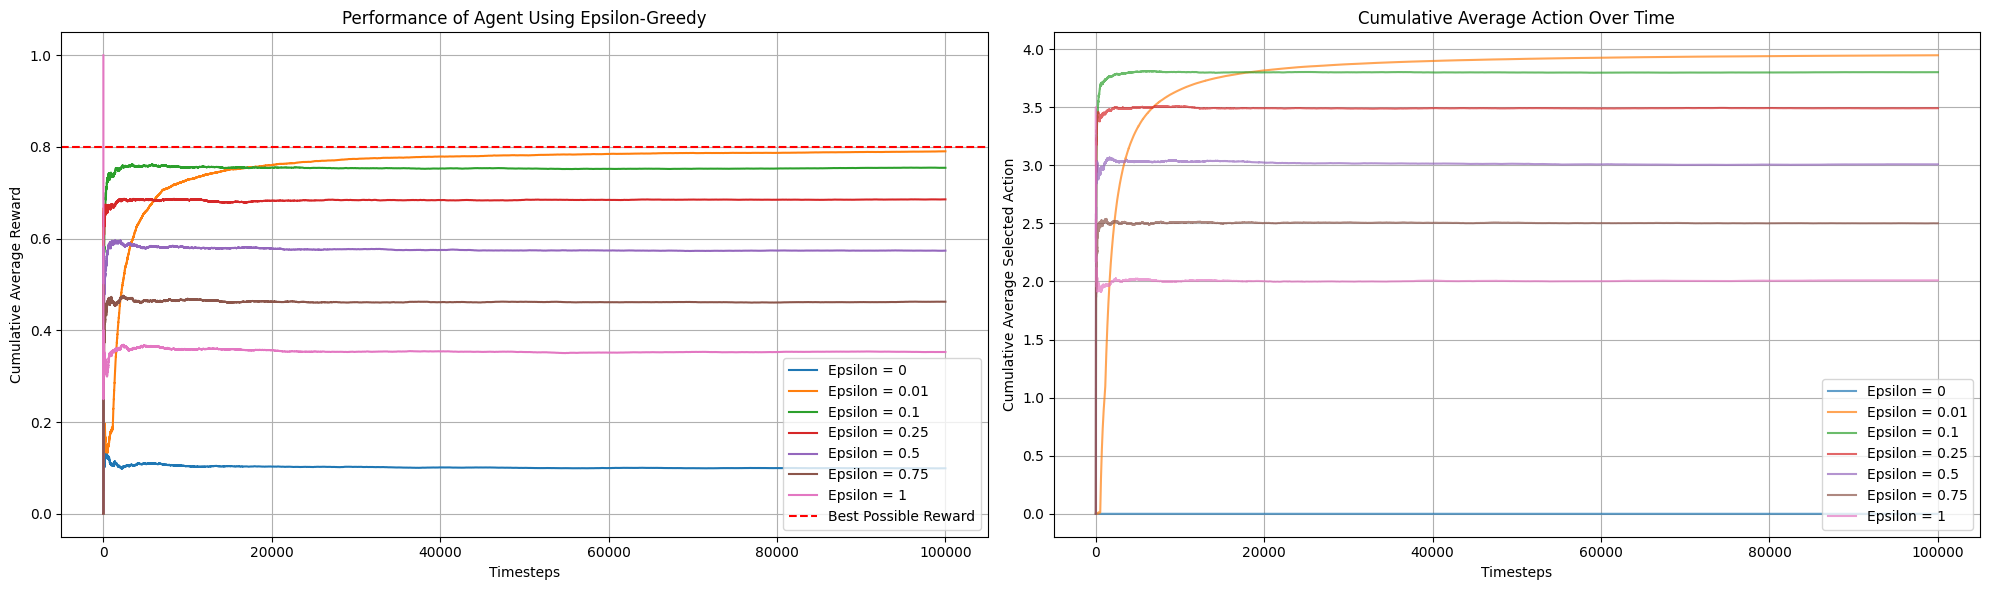

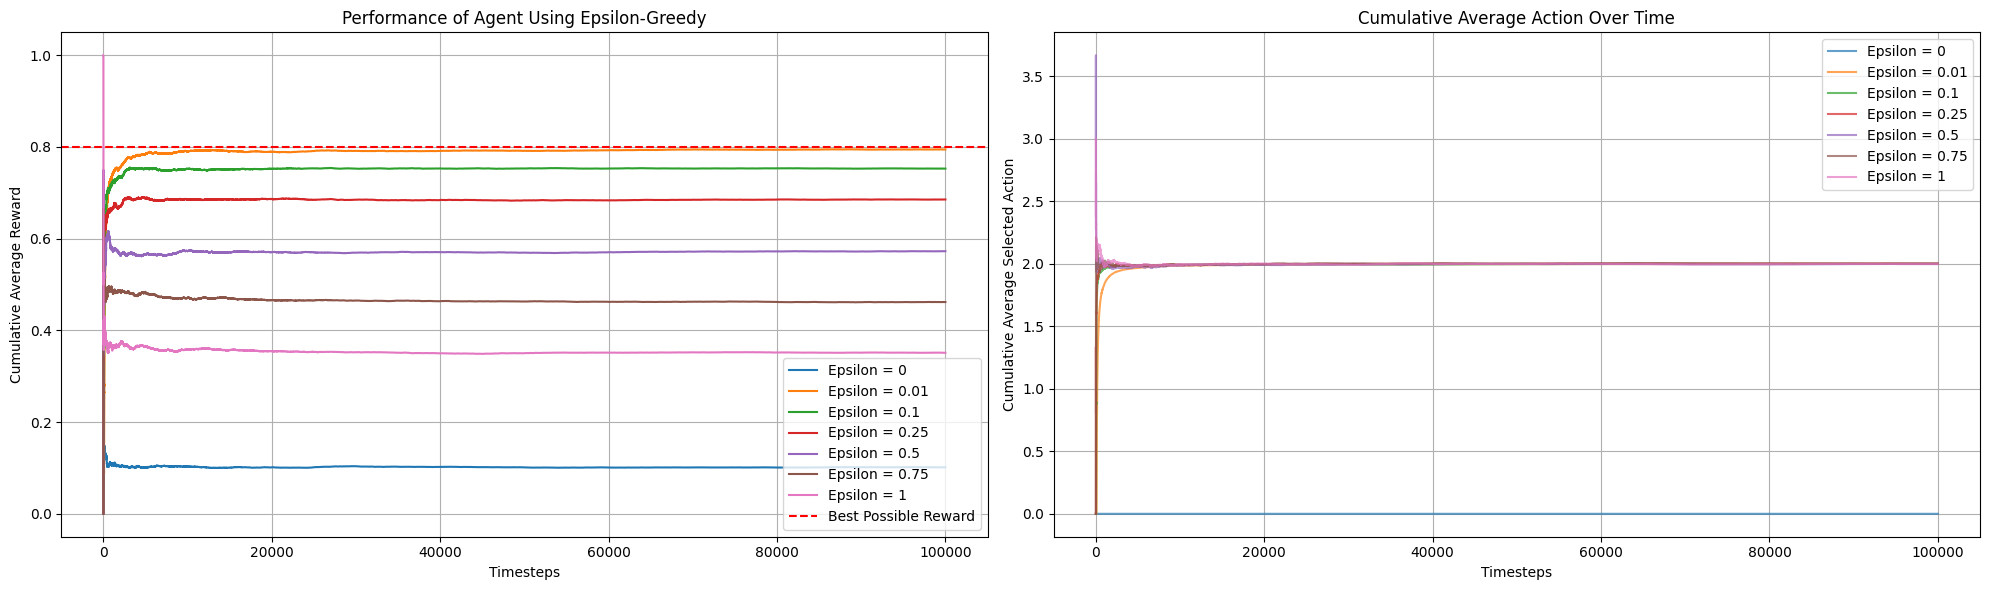

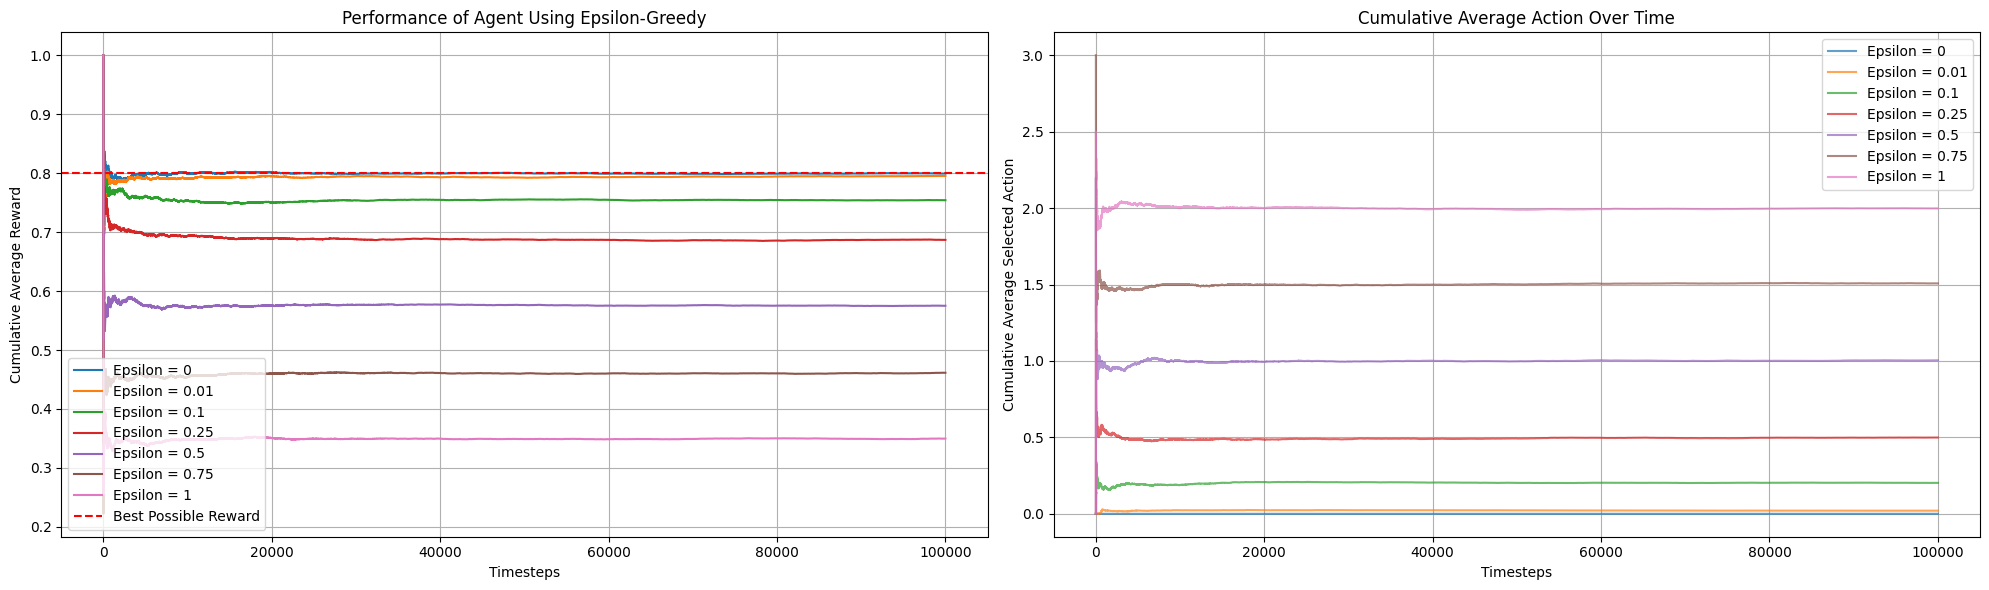

In [5]:
if __name__ == "__main__":

    cumulative_rewards_results = {}
    actions_selected_results = {}

    cumulative_rewards_results1 = {}
    actions_selected_results1 = {}

    cumulative_rewards_results2 = {}
    actions_selected_results2 = {}

    n_bandits = 5     # Number of Bandits
    n_steps = 100000    # Number of Timesteps
    epsilon_values = [0,0.01, 0.1, 0.25, 0.5, 0.75, 1]
    # rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 

    method = "Epsilon-Greedy"  

    for epsilon in epsilon_values:
        rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[epsilon] = cumulative_rewards
        actions_selected_results[epsilon] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")
    print(f"Hidden reward distributions: {hidden_rewards}")
    
    for epsilon in epsilon_values:
        rewards = [0.1, 0.15, 0.8, 0.5, 0.2] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results1[epsilon] = cumulative_rewards
        actions_selected_results1[epsilon] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")
    print(f"Hidden reward distributions: {hidden_rewards}")

    for epsilon in epsilon_values:
        rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, epsilon=epsilon, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results2[epsilon] = cumulative_rewards
        actions_selected_results2[epsilon] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"epsilon = {epsilon}: Average reward = {np.mean(rewards):.2f}")

    print(f"Hidden reward distributions: {hidden_rewards}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for epsilon, cumulative_rewards in cumulative_rewards_results.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"Epsilon = {epsilon}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for epsilon, actions_selected in actions_selected_results.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"Epsilon = {epsilon}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for epsilon, cumulative_rewards in cumulative_rewards_results1.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"Epsilon = {epsilon}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for epsilon, actions_selected in actions_selected_results1.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"Epsilon = {epsilon}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for epsilon, cumulative_rewards in cumulative_rewards_results2.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"Epsilon = {epsilon}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for epsilon, actions_selected in actions_selected_results2.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"Epsilon = {epsilon}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()




### Result Analysis


#### 1.the highest reward is associated with the last option
Time step 10,000
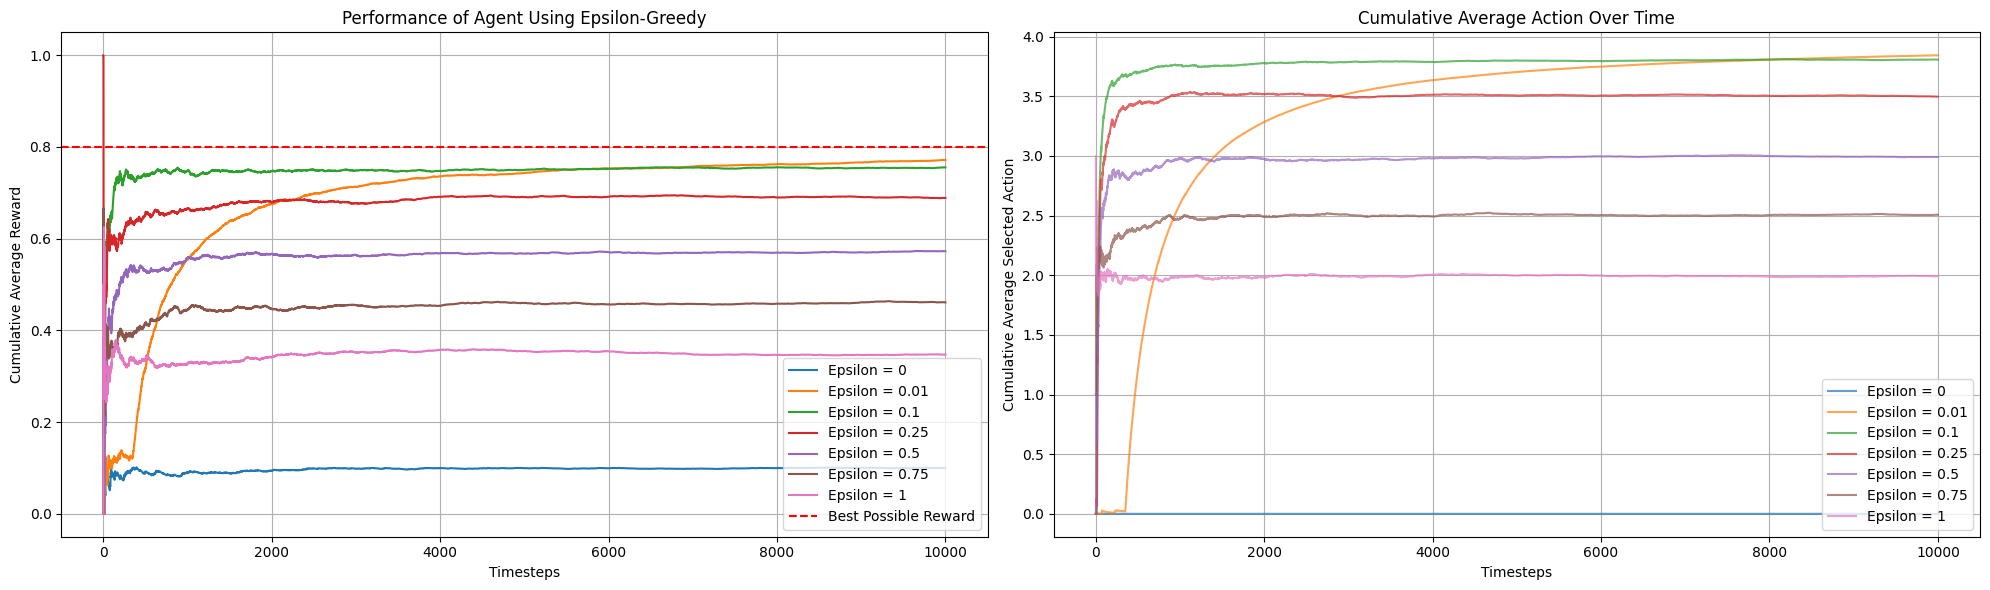

Time step 100,000
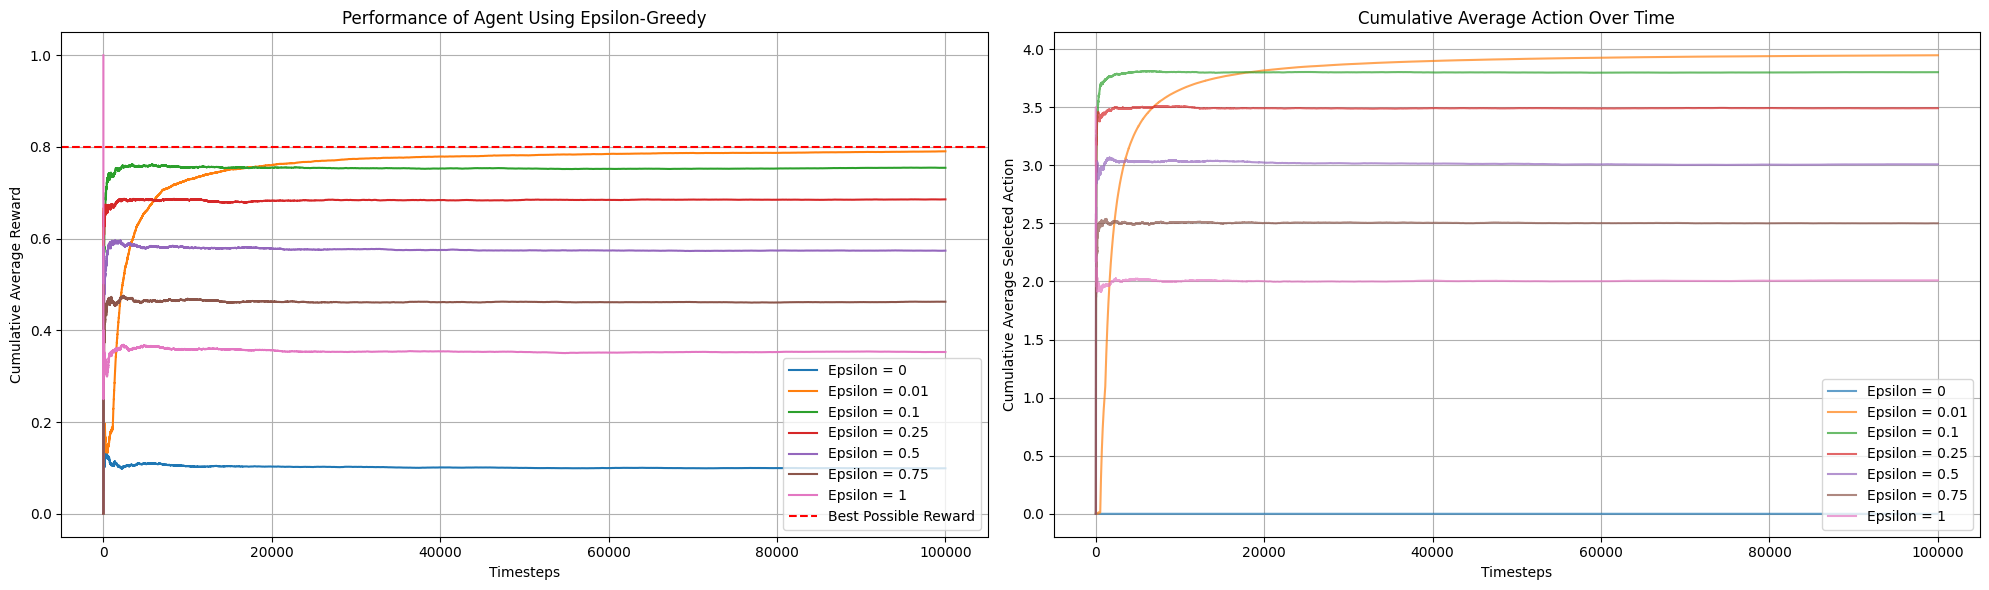

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1, 0.15, 0.2, 0.5, 0.8], where the highest reward is associated with the last option.

From the results, we observe that
- When Epsilon = 0 (no exploration at all), the agent selects the machine that initially provides the highest reward it encounters. It does not attempt to explore further, resulting in a low cumulative reward since it fails to discover the best machine.
Conversely, 
- when Epsilon = 1 (exploring all the time), the agent discovers the machine with the highest hidden reward. However, since it continues exploring indefinitely instead of exploiting the best option, the cumulative reward remains low.

**Best Epsilon for This Case**

Epsilon = 0.1 or 0.25 gives the highest cumulative reward. These values help the agent explore enough to find the best machine but still focus on using it efficiently. This avoids getting stuck too early (like in ε = 0) and too much randomness (like in ε = 1).

**Final Selection Behavior: How the Agent Chooses a Machine Over Time**

With Epsilon = 0, the agent sticks to its first choice and never finds the best machine. With Epsilon = 0.1, the agent gradually learns to select the best option and consistently picks it in the later steps.

#### 2. the highest reward is associated with the third option (middle position)
Time step 10,000
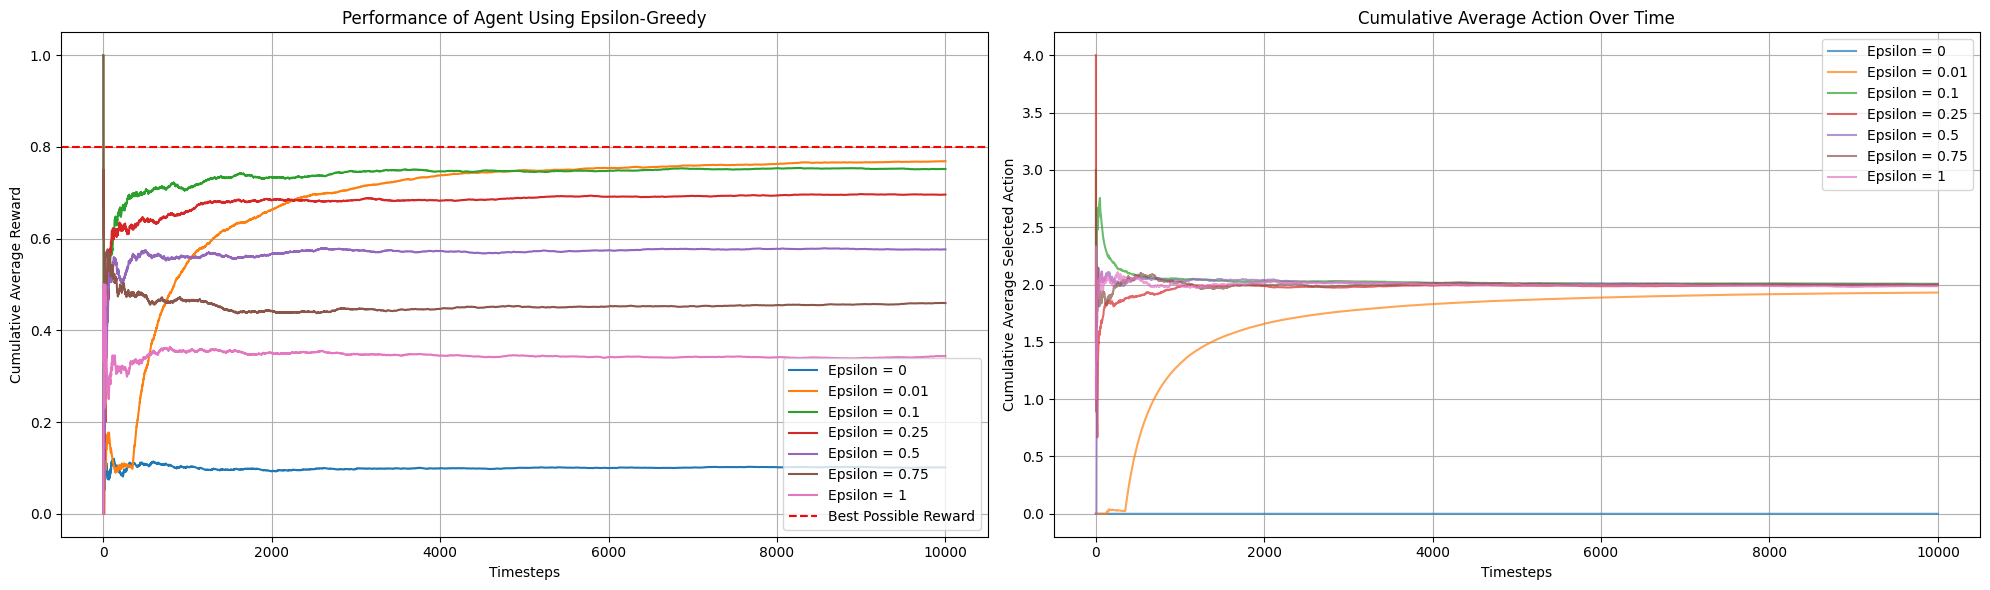

Time step 100,000
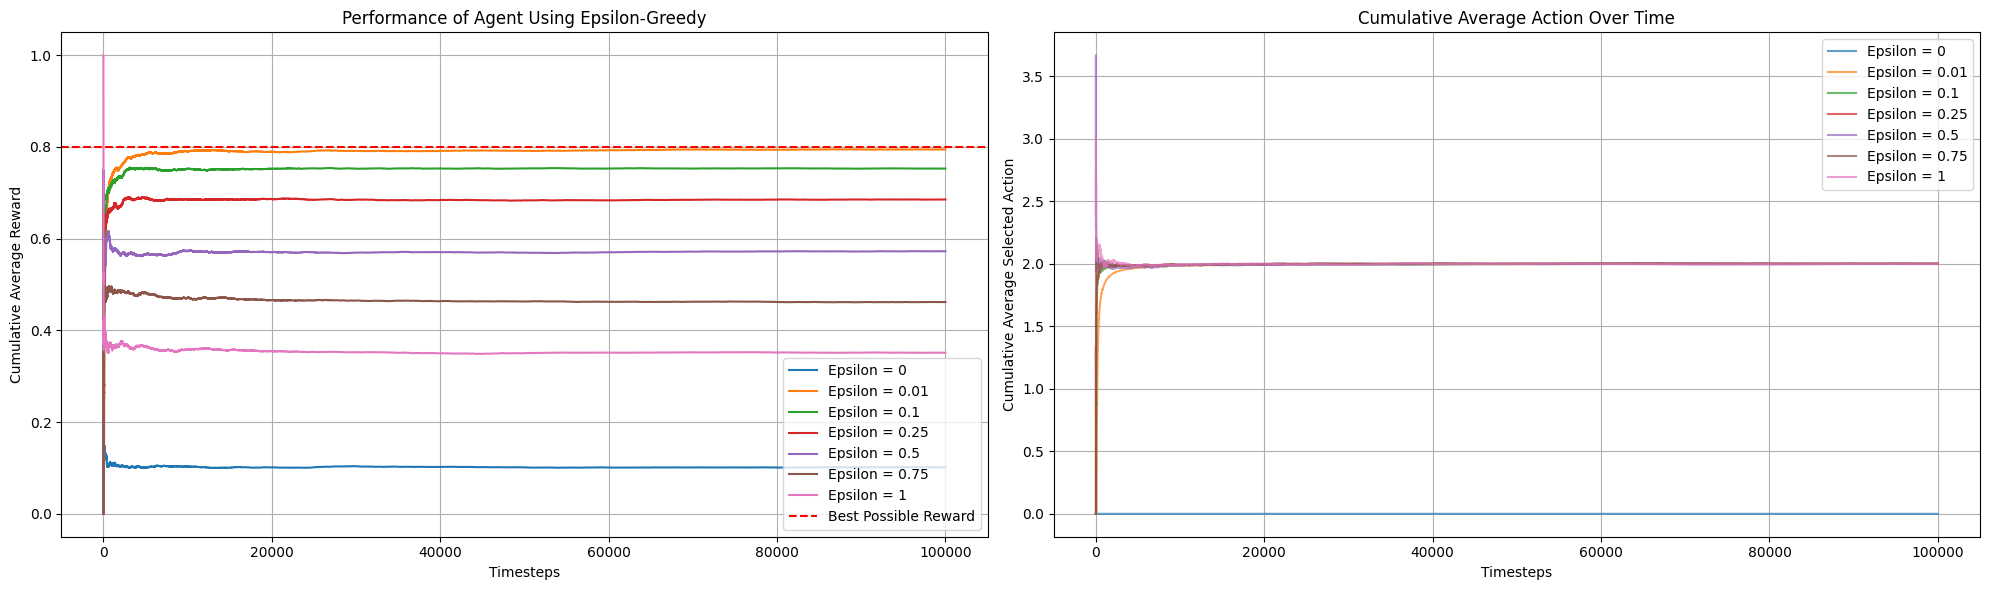

In this experiment, the Bandit problem is designed with hidden reward distributions as follows
[0.1  0.15 0.8  0.5  0.2 ], where the highest reward is associated with the third option (middle position).

From the results, we observe that

Worst Epsilon Value: Epsilon = 0 
- The agent selects the first machine it encounters that provides a decent reward.
- Since it does not explore further, it fails to discover the optimal machine, resulting in a low cumulative reward.
- In the end, the agent remains stuck with a suboptimal choice because it never attempted to search beyond its initial selection.

Best Epsilon Value: Epsilon = 0.1 
- The agent explores just enough to discover the best machine but still commits to exploiting it once found.
- This results in a high cumulative reward, as it quickly shifts from exploration to exploitation.
- By the final timesteps, the agent consistently selects the best machine, indicating that it has successfully learned the optimal choice.


**Final Selection Behavior: How the Agent Chooses a Machine Over Time**

Epsilon = 0 (Worst Case) → Stuck with Initial Choices
- The agent picks one of the first machines it encounters and never changes its preference.
- This means it misses the high-reward option that appears later in the sequence.

Epsilon = 0.1 (Best Case) → Finds and Sticks to the Best Machine
- The agent gradually refines its choices and converges on the highest-reward machine in the middle.
- By the final timesteps, it consistently selects the optimal option, demonstrating that its exploration was sufficient but not excessive.

#### 3.  the highest reward is in the first option
Time Step 10,000
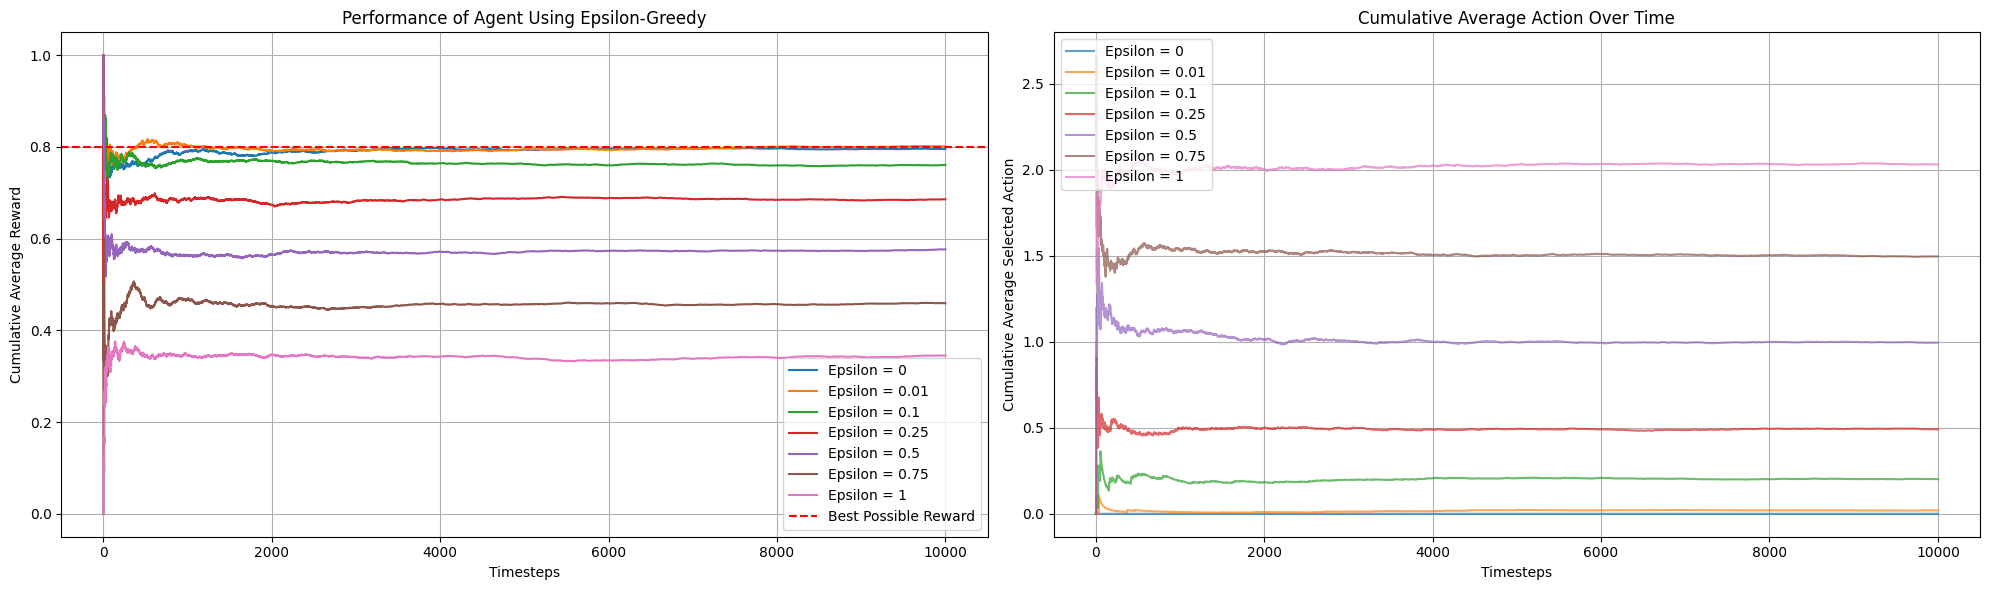

Time Step 100,000
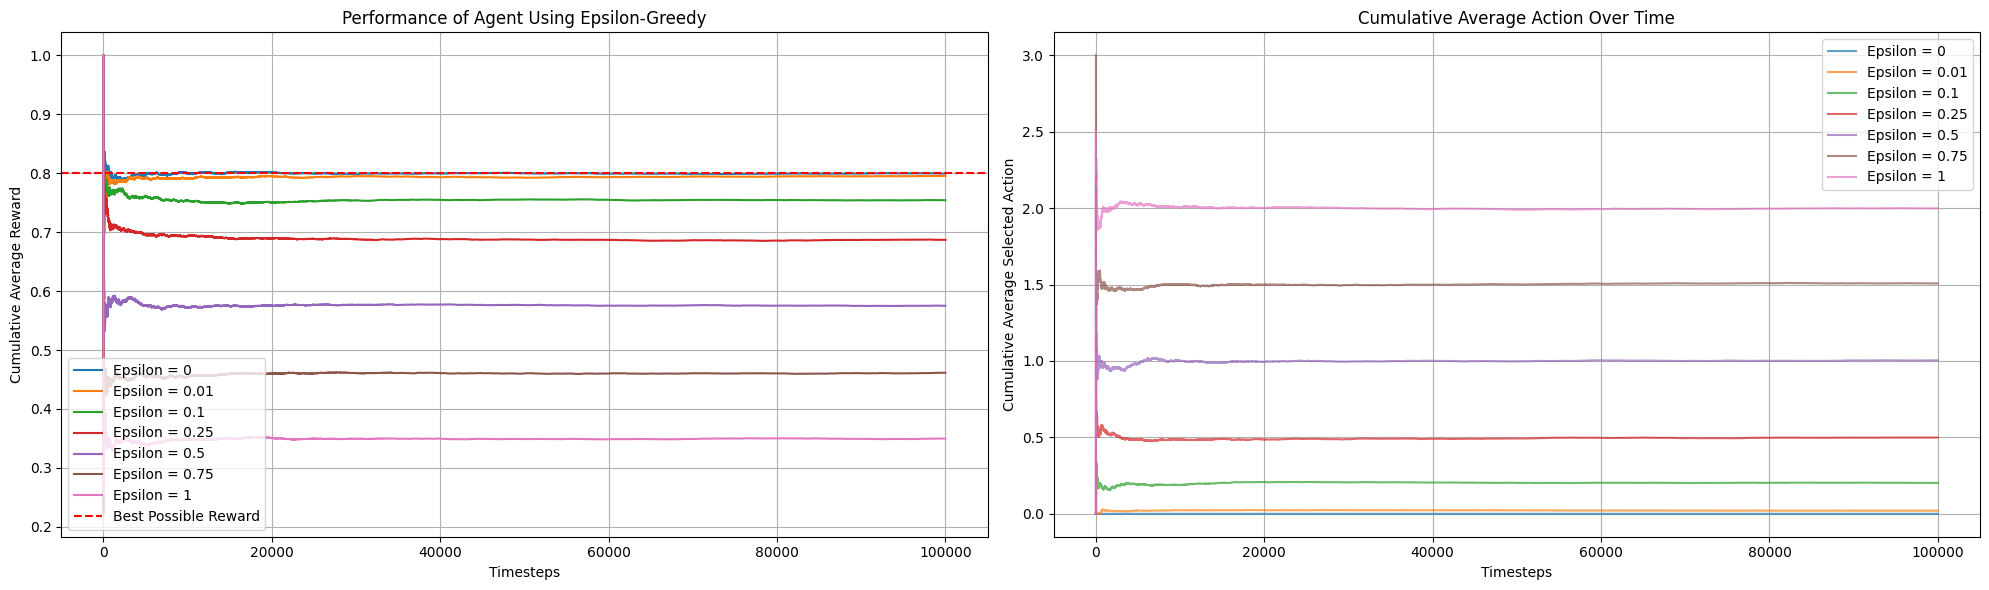

In this experiment, the Bandit problem is designed with hidden reward distributions as follows:
[0.8, 0.15, 0.2, 0.5, 0.1], where the highest reward is in the first option.

Worst Epsilon Value: Epsilon = 1 
- The agent keeps exploring indefinitely, preventing it from settling on the best machine.
- Since the highest reward is available right at the beginning, excessive exploration delays optimal performance, leading to low cumulative reward.
- In the end, the agent continues selecting different machines instead of fully exploiting the best one.

Best Epsilon Value: Epsilon = 0

- Since the highest reward is already in the first position, an agent that does not explore at all performs exceptionally well.
- The agent immediately selects the best machine and never deviates, leading to the highest cumulative reward.
- This is a rare case where no exploration is actually the best strategy because the optimal option is encountered first.


**Final Selection Behavior: How the Agent Chooses a Machine Over Time**

Epsilon = 1 (Worst Case) → Keeps Switching Actions
- The agent never fully settles on the best machine, instead continuing to explore other (suboptimal) options.
- This results in low final reward since the best option is not consistently chosen.

Epsilon = 0 (Best Case) → Instantly Locks onto the Best Machine
- The agent immediately identifies the highest-reward machine and never changes its choice.
- This leads to maximum efficiency, as it avoids unnecessary exploration.

## Summary of Epsilon-Greedy Performance
1. Optimal Policy Convergence Depends on Reward Structure

    When the best action is in the first position, greedy selection (ε = 0) converges immediately.
    When the best action is further down the action space, higher initial exploration (ε > 0) is required to ensure discovery.

2. Over-Exploration (Epsilon = 1) Is Always Suboptimal

    Pure exploration prevents policy convergence, as the agent never fully exploits the optimal action.
    This leads to lower long-term expected rewards, especially when the optimal action is easily accessible.

3. Under-Exploration (Epsilon = 0) Leads to Premature Convergence

    If the best action is not immediately accessible, an ε = 0 strategy results in suboptimal policy convergence.
    This highlights the importance of balancing exploration in dynamic action spaces.


**Implications for Multi-Armed Bandit Optimization**
In static environments, a well-tuned ε-greedy strategy (ε ≈ 0.1 - 0.25) ensures efficient learning, allowing the agent to explore early and exploit once the best arm is identified.

## Part 3: Implementing UCB


## Experimental
**hypothesize**
1. If c approaches 0, the agent will fail to explore sufficiently and may not find the most rewarded bandit.
2. If c approaches to infinite, the agent will continuously observe (exploit) the bandits without sufficient exploration, also failing to find the most rewarded bandit.

**Observation** : We analyzed the average reward for each c value 3 times by change the most high reward around bandits 

We conducted an experiment by running an epsilon-greedy algorithm with the following c values:[ 0, 0.01, 0.1, 0.5, 1, 2, 5, 7, 10]. Each value was tested 3 times, 

1st : [0.1  0.15 0.2  0.5  0.8 ]

2nd : [0.1  0.15 0.8  0.5  0.2 ]

3rd : [0.8  0.15 0.2  0.5  0.1 ]

In [ ]:
if __name__ == "__main__":

    cumulative_rewards_results = {}
    actions_selected_results = {}

    cumulative_rewards_results1 = {}
    actions_selected_results1 = {}

    cumulative_rewards_results2 = {}
    actions_selected_results2 = {}

    n_bandits = 5     # Number of Bandits
    n_steps = 100000    # Number of Timesteps
    c_values = [ 0, 0.01, 0.1, 0.5, 1, 2, 5, 7, 10]
    # rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 

    method = "UCB"  

    for c in c_values:
        rewards = [0.1, 0.15, 0.2, 0.5, 0.8] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results[c] = cumulative_rewards
        actions_selected_results[c] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")
    print(f"Hidden reward distributions: {hidden_rewards}")
    
    for c in c_values:
        rewards = [0.1, 0.15, 0.8, 0.5, 0.2] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results1[c] = cumulative_rewards
        actions_selected_results1[c] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")
    print(f"Hidden reward distributions: {hidden_rewards}")

    for c in c_values:
        rewards = [0.8, 0.15, 0.2, 0.5, 0.1] 
        custom_rewards = rewards.copy()  # Creates a separate list
        rewards, cumulative_rewards, hidden_rewards, actions_selected = run_experiment(
            n_bandits=n_bandits, n_steps=n_steps, c=c, method=method, custom_rewards=custom_rewards
        )
        cumulative_rewards_results2[c] = cumulative_rewards
        actions_selected_results2[c] = actions_selected
        # print(  cumulative_rewards_results)

        print(f"c = {c}: Average reward = {np.mean(rewards):.2f}")

    print(f"Hidden reward distributions: {hidden_rewards}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for c, cumulative_rewards in cumulative_rewards_results.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"c = {c}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for c, actions_selected in actions_selected_results.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"c = {c}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for c, cumulative_rewards in cumulative_rewards_results1.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"c = {c}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for c, actions_selected in actions_selected_results1.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"c = {c}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # --- Plot Cumulative Rewards ---
    for c, cumulative_rewards in cumulative_rewards_results2.items():
        axes[0].plot(range(len(cumulative_rewards)), cumulative_rewards, label=f"c = {c}")

    axes[0].axhline(y=np.max(hidden_rewards), color='r', linestyle='--', label="Best Possible Reward")
    axes[0].set_title(f"Performance of Agent Using {method}")
    axes[0].set_xlabel("Timesteps")
    axes[0].set_ylabel("Cumulative Average Reward")
    axes[0].legend()
    axes[0].grid()

    # --- Compute and Plot Cumulative Average of Selected Actions ---
    for c, actions_selected in actions_selected_results2.items():
        timesteps = np.arange(1, len(actions_selected) + 1)
        cumulative_avg_actions = np.cumsum(actions_selected) / timesteps  # Compute cumulative average

        axes[1].plot(timesteps, cumulative_avg_actions, label=f"c = {c}", alpha=0.7)

    axes[1].set_title(f"Cumulative Average Action Over Time")
    axes[1].set_xlabel("Timesteps")
    axes[1].set_ylabel("Cumulative Average Selected Action")
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()


c = 0: Average reward = 0.50
c = 0.01: Average reward = 0.80
c = 0.1: Average reward = 0.50
c = 0.5: Average reward = 0.80
c = 1: Average reward = 0.80
c = 2: Average reward = 0.80
c = 5: Average reward = 0.78
c = 7: Average reward = 0.77
c = 10: Average reward = 0.74
Hidden reward distributions: [0.1  0.15 0.2  0.5  0.8 ]


### Result Analysis

#### 1.the highest reward is associated with the last option
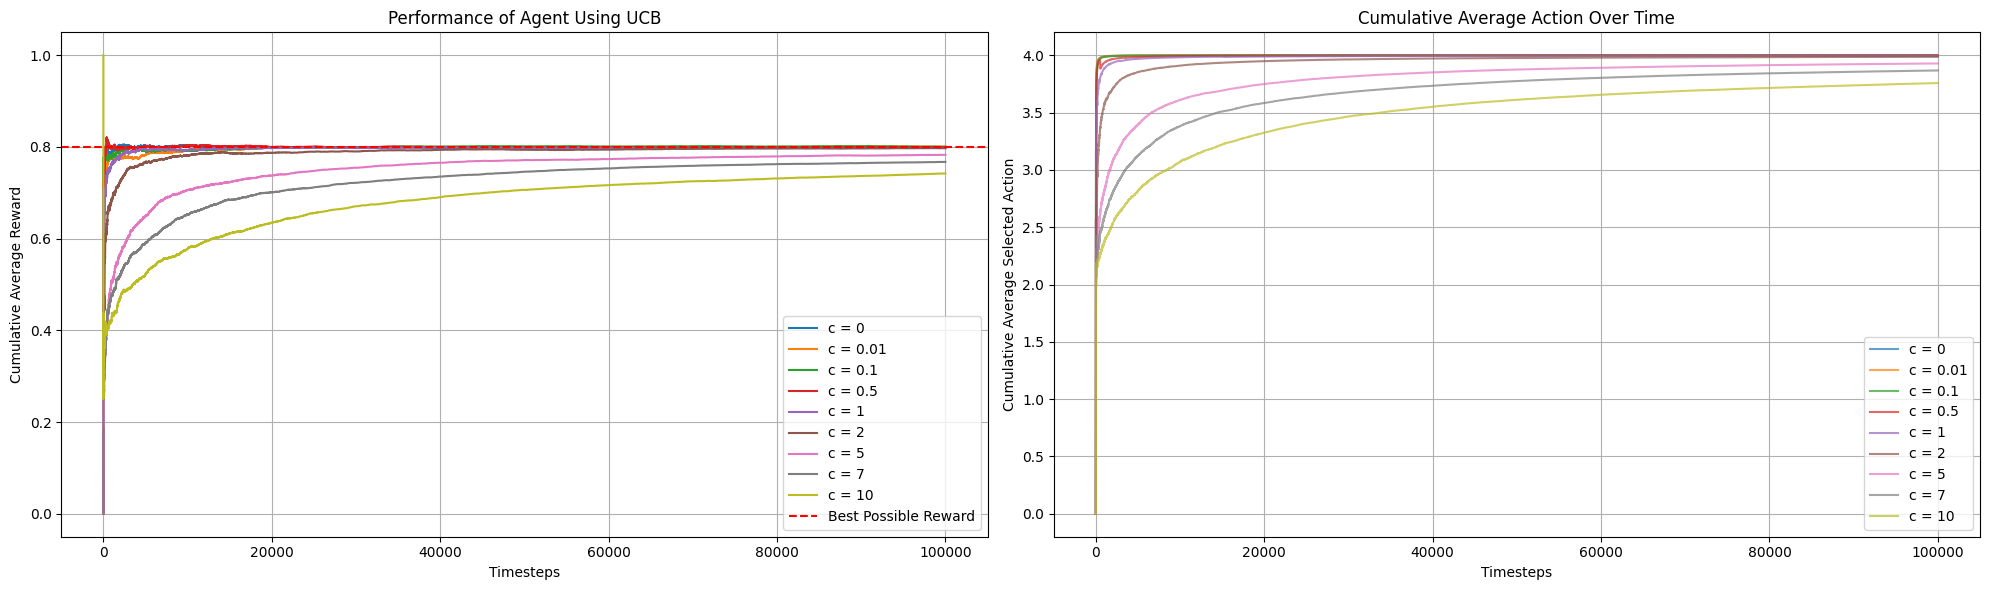

From the graph, we can see that c-values between 0 and 2 give the highest average reward of 0.80. However, when c increases beyond 5, the average reward starts to decrease because the agent keeps exploring new machines instead of committing to the best one. This is clearly shown in the right graph, where the agent tries out all the machines before finally settling on the best one towards the end.


#### 2. the highest reward is associated with the third option (middle position)
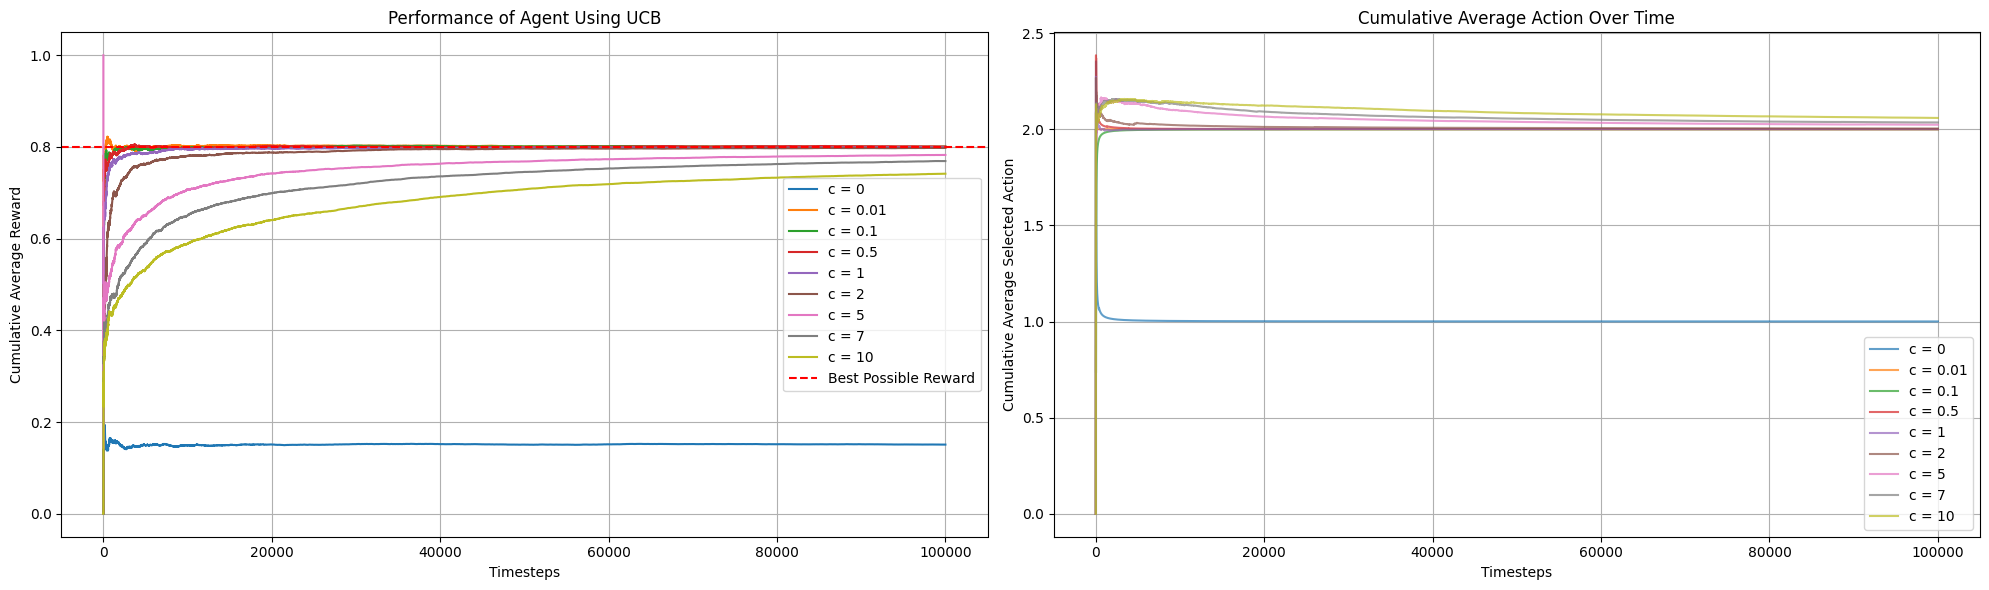

From the graph, we can see that c-values between 0.1 and 2 give the highest average reward, around 0.80, which is the best possible reward. However, when c increases beyond 5, the average reward starts to drop because the agent explores too much, spending too much time testing different machines instead of focusing on the best one.

- Low c-values (c = 0, 0.01) → Not Enough Exploration, Stuck in a Bad Choice
c = 0 performs the worst, as seen in the left graph, where the cumulative reward stays much lower than the best possible reward.
The right graph shows that c = 0 picks one machine early on and never changes, so it fails to find the best option.
c = 0.01 is slightly better because it explores a little, but still not enough to find the best machine.

- Medium c-values (c = 0.1, 0.5, 1, 2) → Good Balance Between Exploration and Exploitation, Best Results
These values help the agent quickly learn and reach the best possible reward (~0.80), as seen in the left graph.
The right graph shows that the agent explores at first but quickly settles on the best machine, leading to strong long-term performance.
c = 0.5 and 1 work the best, as they allow enough exploration but also focus on the best machine quickly.

- High c-values (c = 5, 7, 10) → Too Much Exploration, Slower Learning
The left graph shows that when c goes above 5, the cumulative reward starts to drop, with c = 10 performing the worst (~0.74).
The right graph shows that high c-values make the agent keep testing different machines for a long time before finally choosing the best one.
c = 10 never fully stabilizes, meaning the agent is exploring too much and not using the best machine enough.

#### 3. the highest reward is associated with the first option
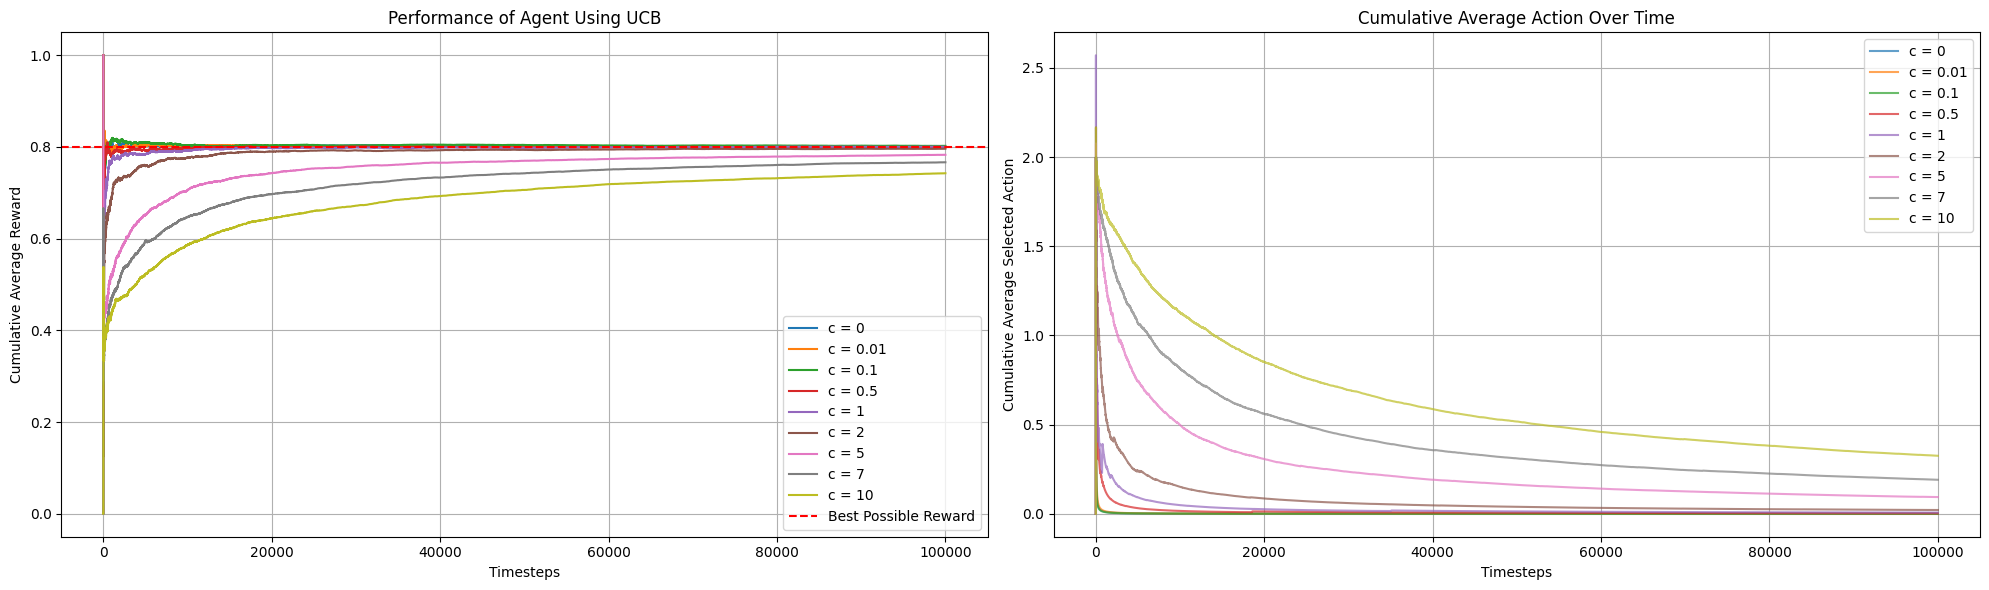

# Epsilon-Greedy VS UCB
 If we comparing epsilon-greedy and UCB results we observe that UCB achieves a higher reward and get closer to maximum possible reward compared to epsilon-greedy, and we Hypothesis that Epsilon-Greedy is uses random exploration, so it sometimes wasted time exploring a bad actions and can even when it should, it might still explore some action, but UCB if confident value is less it will exploit only so its more efficiently.

Epsilon-Greedy 
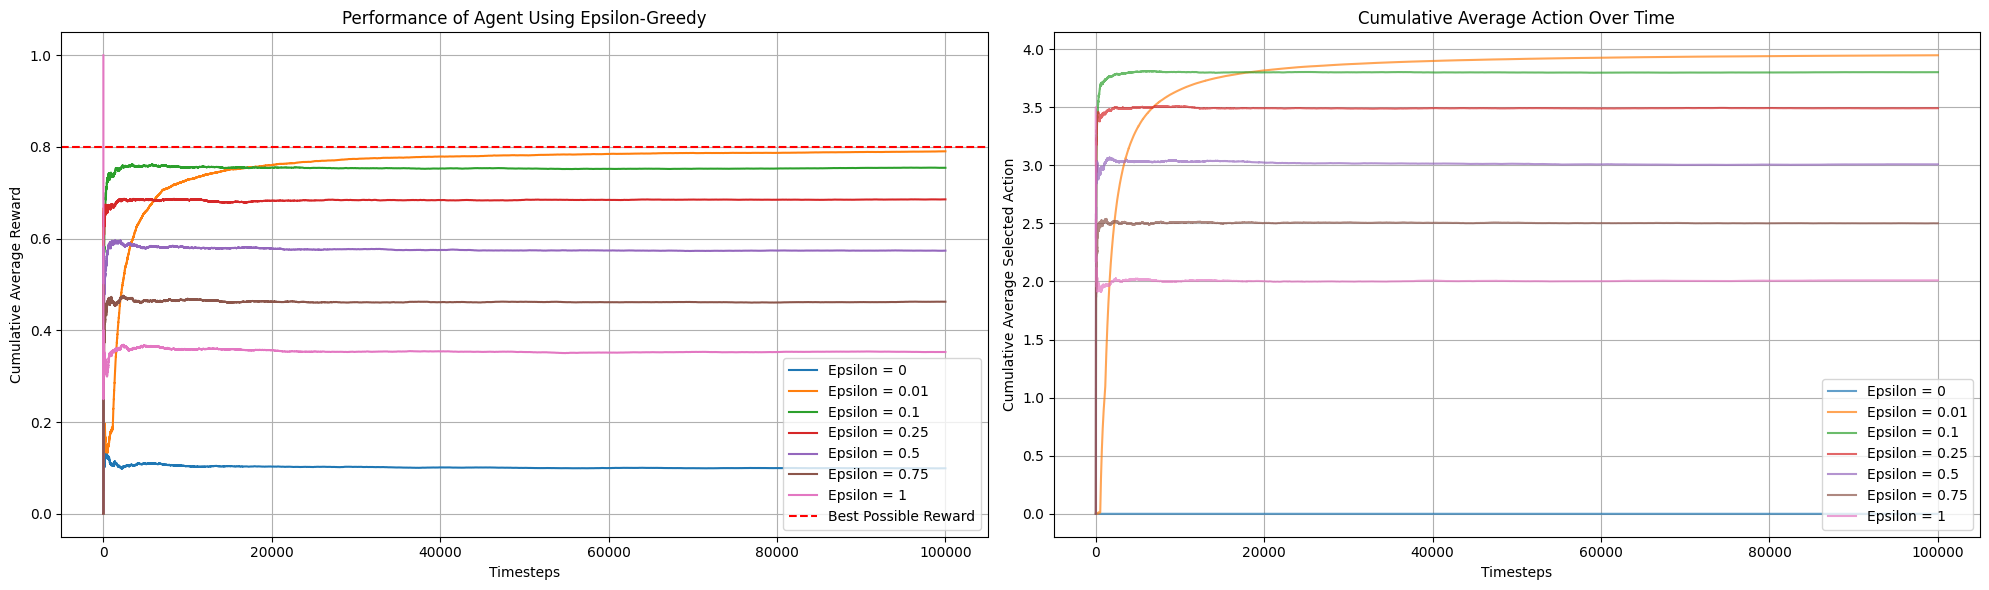

UCB
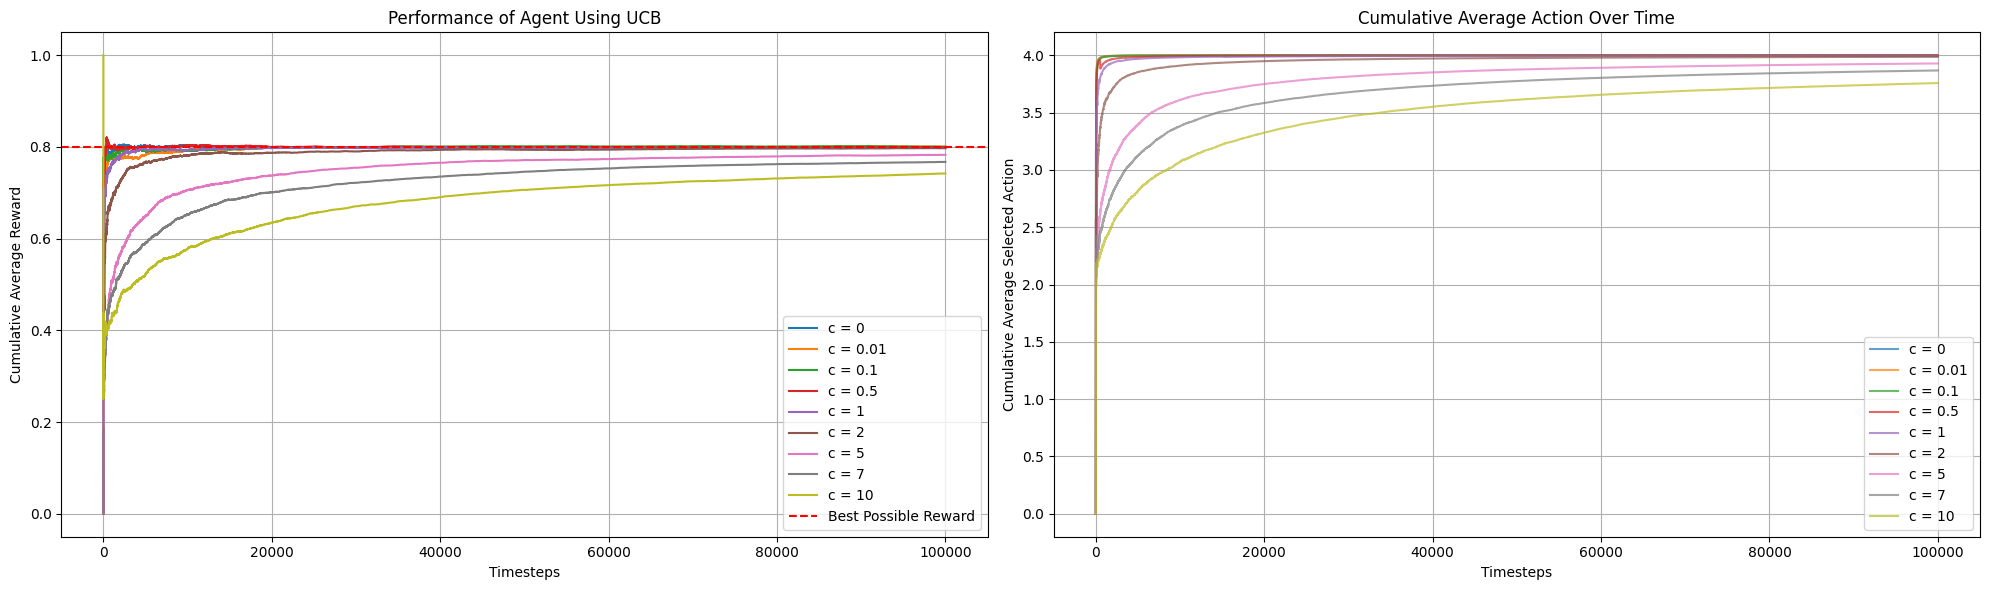